In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
from matplotlib import pyplot as plt, cm
from matplotlib import colors

from common import dalt
from common import hallmark as hm
from common import mockservation as mk
from common import viz
from common import io_ipole as io

In [2]:
def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)
    
    return time, nu, avg, [k.decode("utf-8") for k in knd]

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

def plsed(ax, name, **kwargs):
    time, nu, nuLnu, knd = readsed(name)
    
    pt = np.percentile(nuLnu[:,:,0], [1,50,99], axis=0)
    viz.step(ax, nu, pt[1], **kwargs)
    ax.fill_between(nu, pt[0], pt[2], step='mid', color=kwargs['color'], alpha=1/8, linewidth=0)

In [ ]:
import ehtim as eh
import joblib as jl

obs = eh.obsdata.load_uvfits('data/SgrA_ER6_ver2021-04-15/3599/hops/hops_3599_SGRA_LO+HI_netcal_LMTcal_normalized_10s.uvfits')
obs = obs.avg_incoherent(60) # 1 min averaging

d    = obs.unpack(['u', 'v', 'vis'])
uvd0 = np.sqrt(d.u * d.u + d.v * d.v)
amp0 = abs(d.vis)

jl.dump(uvd0, 'uvd0.jl')
jl.dump(amp0, 'amp0.jl')

In [3]:
import joblib as jl
uvd0 = jl.load('uvd0.jl')
amp0 = jl.load('amp0.jl')

In [4]:
def plva(name):

    mov = readimg(name)
    vis = mk.mockserve(mov, N=512)

    U, V = vis.uvd
    uu = np.linspace( 0,   U/2, num=vis.shape[-1])
    vv = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t  = vis.meta.time.value

    amp = RegularGridInterpolator((t, vv, uu[::-1]), abs     (vis[...,::-1]))
    uvd = np.linspace(0, 1.1e10, round(1e10/1e8)+1)
    
    va = []
    for t0 in tqdm(t):
        s_all = []
        for i in range(-90,90,45):
            phi = np.pi * i / 180
            uu  = uvd * np.cos(phi)
            vv  = uvd * np.sin(phi)

            mask = (uu <= 0)
            p = np.array([np.repeat(t0, np.sum( mask)),  vv[ mask],  uu[ mask]]).T
            m = np.array([np.repeat(t0, np.sum(~mask)), -vv[~mask], -uu[~mask]]).T
    
            s = np.zeros(len(uvd))
            s[ mask] = amp(p)
            s[~mask] = amp(m)
        
            s_all.append(s/s[0])
        va.append(s_all)
            
    return uvd, np.array(va)

uvd, va = plva('cache/Illinois_thermal_w5/Sa+0.94_i30/gt_Rh40_230GHz.h5')

pc = np.percentile(va.reshape(-1, va.shape[-1]), [1,50,99], axis=0)
plt.semilogy(uvd, pc[1])
c = colors.to_rgb('C0')
plt.fill_between(uvd, pc[0], pc[2], facecolor=c+(0.1,), edgecolor=c+(0.5,))

In [5]:
uvd, vaA = plva('cache/Frankfurt_thermal/SANEa0.50_i30/gt_Rh40_230GHz.h5')
uvd, vaB = plva('cache/Illinois_thermal_w5/Ma+0.5_i30/gt_Rh40_230GHz.h5')
#uvd, vaB = plva('cache/Illinois_thermal_w5/Sa+0.94_i30/gt_Rh40_230GHz.h5')
uvd, vaC = plva('cache/Hamr_varkappa/mad_a0.5_i30/gt_Rh160_230GHz.h5')

100%|████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 336.74it/s]


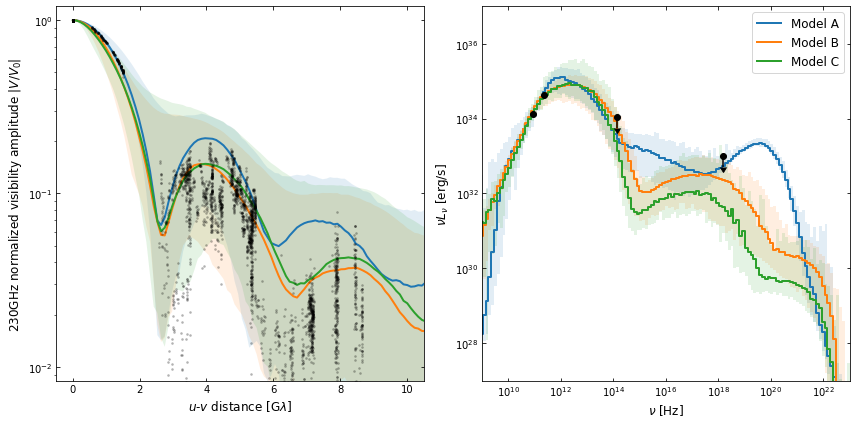

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

ptA = np.percentile(vaA.reshape(-1, vaA.shape[-1]), [1,50,99], axis=0)
ptB = np.percentile(vaB.reshape(-1, vaB.shape[-1]), [1,50,99], axis=0)
ptC = np.percentile(vaC.reshape(-1, vaC.shape[-1]), [1,50,99], axis=0)

mA = np.median(vaA, axis=0)
mB = np.median(vaB, axis=0)
mC = np.median(vaC, axis=0)

c = colors.to_rgb('C0')
axes[0].fill_between(uvd/1e9, ptA[0], ptA[2], facecolor=c+(1/8,), edgecolor=None)
axes[0].plot(uvd/1e9, mA[2,:], linewidth=2, color=c)

c = colors.to_rgb('C1')
axes[0].fill_between(uvd/1e9, ptB[0], ptB[2], facecolor=c+(1/8,), edgecolor=None)
axes[0].plot(uvd/1e9, mB[2,:], linewidth=2, color=c)

c = colors.to_rgb('C2')
axes[0].fill_between(uvd/1e9, ptC[0], ptC[2], facecolor=c+(1/8,), edgecolor=None)
axes[0].plot(uvd/1e9, mC[2,:], linewidth=2, color=c)

axes[0].set_yscale('log')
axes[0].set_xlim(-0.5, 10.5)
axes[0].set_ylim(0.1/12, 0.1*12)
axes[0].set_ylabel('230GHz normalized visibility amplitude $|V/V_0|$', fontsize=12)
axes[0].set_xlabel('$u$-$v$ distance [G$\lambda$]',                    fontsize=12)
axes[0].tick_params(
    axis='both',
    direction='in',
    top=True,
    right=True)

#axes[0].scatter(uvd0/1e9, amp0, s=1, color='black', alpha=0.1, zorder=2)
axes[0].scatter(uvd0/1e9, amp0, s=3, color='black', alpha=0.2, zorder=2)

plsed(axes[1], 'cache/Illinois_thermal_w5/Sa+0.94_i30/sed_Rh40.h5', label=['Model A'], color='C0')
plsed(axes[1], 'cache/Illinois_thermal_w5/Ma+0.5_i30/sed_Rh40.h5',  label=['Model B'], color='C1')
plsed(axes[1], 'cache/Hamr_varkappa/mad_a0.5_i30/sed_Rh160.h5',     label=['Model C'], color='C2')
axes[1].set_xlim(1e9,  1e23)
axes[1].set_ylim(1e27, 1e37)
axes[1].set_xlabel(r'$\nu$ [Hz]',          fontsize=12)
axes[1].set_ylabel(r'$\nu L_\nu$ [erg/s]', fontsize=12)
axes[1].tick_params(
    axis='both',
    direction='in',
    top=True,
    right=True)
axes[1].errorbar(
    [86e9, 230e9, 1.4141e+14, 1.45e18], 
    [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
    yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
    uplims=[False,False,True,True],
    fmt='o', color='k',
)
axes[1].legend(fontsize=12)
    
fig.tight_layout()

fig.savefig('output/bestbets.pdf')